## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Features
* gender
* age
* age_quantile_range
* age_quantile_label
* __customer_id__
* date_registered
* days_registered
* days_reg_quantile_range
* days_reg_quantile_label
* income
* income_quantile_range
* income_quantile_label
* transaction_amount
* transaction_cnt
* transaction_aos
* gender_NA
* income_NA
* age_NA
* num_offer_received
* num_bogo_offer_received
* num_info_offer_received
* num_discount_offer_received
* num_offer_viewed
* num_offer_completed
* num_offer_completed_viewed
* num_offer_completed_not_viewed
* num_transactions_no_oc
* num_transactions_oc_direct
* percent_oc_direct_transactions
* num_transactions_oc_indirect
* offer_view_rate
* offer_completion_rate
* total_reward_amount
* avg_reward_per_oc_transaction
* transaction_oc_amount
* transaction_aos_oc
* transaction_no_oc_amount
* transaction_aos_no_oc
* num_bogo_offer_viewed
* num_info_offer_viewed
* num_discount_offer_viewed
* num_bogo_offer_completed
* num_info_offer_completed
* num_discount_offer_completed
* median_offer_duration
* avg_offer_completion_time
* avg_hrs_bw_transactions
* num_oc_ch_web
* num_oc_ch_social
* num_oc_ch_mobile
* num_oc_ch_email
* avg_offered_received_freq
* info_view_rate


#### Implementation ideas
* model 1: predict spend per customer >> SMOTE to increase instances with offer_completed (oversample) + regression
* model 2: predict offer_completed per customer (1 or 0) >> SMOTE + classification

* Problem: Your task is to combine transaction, demographic and offer data to determine 
* which demographic groups respond best to which offer type.

* for per offer_id:
    * grab only transactions with a single offer_id completed and customers
    * define offer_completed as both offer_viewed and offer_completed exist
    * Conduct feature importance analysis using regression model to predict spend

## Insights

* Number of customers who have completed offers is high with 77% of all converted customers have used offers
* 97.5% of customers in profile have converted at least once. Conversion isn't the problem, but benefits of offers might be looked at deeper. Does it increase spend?
* Although 77% of customers have at least one offer completed, but % of transactions with offer completed stands at about 22%
* Takeaway: A lot of customers have been exposed and used offers at least once at some point, but only about quarter of transactions are associated with offer-completed.

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from base_transforms import BaseTransformDF

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# read in the json files
profile = pd.read_json('data/profile.json', orient='records', lines=True)

## starbucks_transaction_engagement.csv.gz

In [5]:
%%time

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', <number of rows>)

file_name = 'starbucks_transaction_engagement.csv.gz' 
file_gzip = os.path.join(os.getcwd(), 'data', file_name)

trans_engage = pd.read_csv(file_gzip, compression='gzip')
trans_engage.head()

CPU times: user 620 ms, sys: 49.4 ms, total: 670 ms
Wall time: 672 ms


,record_id,transaction_id,customer_id,transaction_time,transaction_amount,offer_completed,offer_completed_time,offer_id,offer_received,offer_received_time,offer_viewed,offer_viewed_time,reward,difficulty,duration,num_channels,ch_web,ch_email,ch_mobile,ch_social,type_bogo,type_informational,type_discount
0,ed32379b6d6c4cb8ab4debd89c15ba5e,32fb71cb5681489b89f62cd5ac034605,02c083884c7d45b39cc68e1314fec56c,0,0.83,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0f7bae52f06f4fd8ac4e22c0e6cc00a4,df47e3e0010d49c082e5b92312dd69af,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,0,2906b810c7d4411798c6938adc9daaa5,1,0,1,0,2.0,10.0,168.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,f7fe113f418e44c7b7c20a9506b28bf4,07ca9825a14946b2a7114f76ec0cc7e2,54890f68699049c2a04d415abc25e717,0,13.23,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,362e4d173c2347e790e3a7eb13f5e476,e587cc3deee540b9a7a4bbc140770171,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0,-1,no-offer,0,-1,0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,fd5df68f397e4a1ea0f980a3c932745d,298cf73db6774654b3e5433536656871,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,-1,2.0,10.0,240.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


## Train & Test Split

In [6]:
profile = profile.rename(columns={'id': 'customer_id', 'became_member_on': 'date_registered'})

profile['date_registered'] = profile['date_registered'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d"))

profile.isnull().mean().reset_index().rename(columns={'index':'column_name', 0:'missing_values'})

,column_name,missing_values
0,gender,0.127941
1,age,0.000000
2,customer_id,0.000000
3,date_registered,0.000000
4,income,0.127941


In [7]:
profile.head()

,gender,age,customer_id,date_registered,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [8]:
# calculate total transactions and total transaction amount per customer_id 
rename_columns={'transaction_id': 'transaction_cnt'}
transaction_cnt = trans_engage.groupby('customer_id')['transaction_id'].nunique().reset_index().rename(columns=rename_columns)

transaction_amount = trans_engage.groupby('customer_id')['transaction_amount'].sum().reset_index()

transactions = transaction_amount.merge(transaction_cnt, how='left', on='customer_id')
transactions['transaction_aos'] = round(1.0 * transactions['transaction_amount'] / transactions['transaction_cnt'], 2)

transactions.head()


,customer_id,transaction_amount,transaction_cnt,transaction_aos
0,0009655768c64bdeb2e877511632db8f,127.60,8,15.95
1,00116118485d4dfda04fdbaba9a87b5c,4.09,3,1.36
2,0011e0d4e6b944f998e987f904e8c1e5,101.51,5,20.30
3,0020c2b971eb4e9188eac86d93036a77,214.10,8,26.76
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,12.84


In [9]:
# merge profile and transactions, and create members dataframe
members = profile.merge(transactions, how='left', on='customer_id')
members['transaction_amount'] = members['transaction_amount'].fillna(0)
members['transaction_cnt'] = members['transaction_cnt'].fillna(0)
members['transaction_aos'] = members['transaction_aos'].fillna(0)
members.head()

,gender,age,customer_id,date_registered,income,transaction_amount,transaction_cnt,transaction_aos
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,22.52,9.0,2.50
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,77.01,3.0,25.67
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14.30,6.0,2.38
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,180.99,7.0,25.86
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,4.65,3.0,1.55


In [10]:
members.dtypes

gender                        object
age                            int64
customer_id                   object
date_registered       datetime64[ns]
income                       float64
transaction_amount           float64
transaction_cnt              float64
transaction_aos              float64
dtype: object

In [11]:
# split data into train and test
from sklearn.model_selection import train_test_split

# split into inputs and outputs
# X, y = members.iloc[:, :-1], members.iloc[:, -1]
# print(X.shape, y.shape)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(members, 
                                                    members.transaction_aos, 
                                                    test_size=0.33, 
                                                    random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# (11390, 8) (5610, 8) (11390,) (5610,)

(11390, 8) (5610, 8) (11390,) (5610,)


## Imputation: Missing & Incorrect Values

In [12]:
# create flag to show which rows have been imputed 
# imputation of gender, income, and age=118 - take the median from each column

X_train['gender_NA'] = np.where(X_train['gender'].isnull(), 1, 0)
X_train['income_NA'] = np.where(X_train['income'].isnull(), 1, 0)
X_train['age_NA'] = np.where(X_train['age']==118, 1, 0)
X_train['age'] = X_train['age'].apply(lambda x: np.nan if x==118 else x)

X_test['gender_NA'] = np.where(X_test['gender'].isnull(), 1, 0)
X_test['income_NA'] = np.where(X_test['income'].isnull(), 1, 0)
X_test['age_NA'] = np.where(X_test['age']==118, 1, 0)
X_test['age'] = X_test['age'].apply(lambda x: np.nan if x==118 else x)


In [13]:
# impute income, and age column with median values
# impute gender with 'Missing' category

# only use values calculated in train set to impute test set
age_median = X_train.age.median()
income_median = X_train.income.median()

X_train['age'].fillna(age_median, inplace=True)
X_test['age'].fillna(age_median, inplace=True)
 
X_train['income'].fillna(income_median, inplace=True)
X_test['income'].fillna(income_median, inplace=True)

X_train['gender'].fillna('Missing', inplace=True)
X_test['gender'].fillna('Missing', inplace=True)

X_train.head()

,gender,age,customer_id,date_registered,income,transaction_amount,transaction_cnt,transaction_aos,gender_NA,income_NA,age_NA
8486,F,49.0,8afd61052075479bacfe7dec6a27111c,2018-03-14,75000.0,65.38,3.0,21.79,0,0,0
13892,M,68.0,0f4ea68d60614ce2a683c039425f160c,2017-10-09,46000.0,64.10,4.0,16.03,0,0,0
7700,Missing,55.0,21235376597f4d94af106ebba288304c,2015-09-12,64000.0,21.31,12.0,1.78,1,1,1
6045,M,65.0,9c9d2659c4ec499288a96dec70fae500,2017-01-12,76000.0,154.40,6.0,25.73,0,0,0
14096,F,35.0,75f1a3a88b5845feba167c6380f4dba2,2018-05-27,38000.0,17.69,6.0,2.95,0,0,0


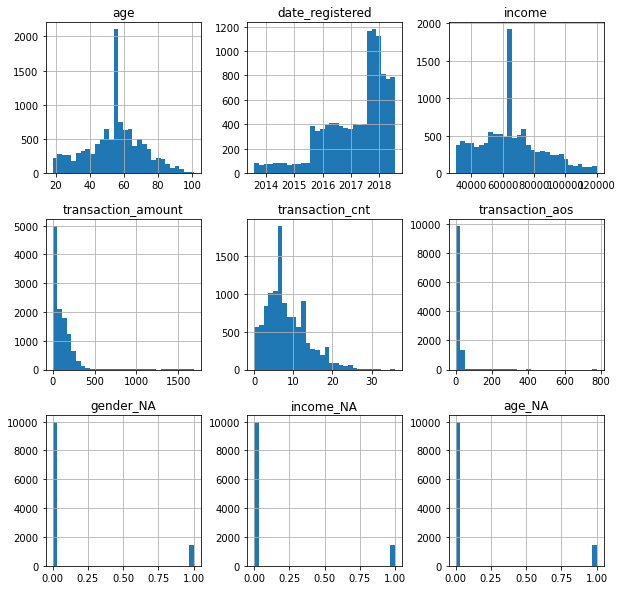

In [14]:
# explore the change in the distributions after the median imputation
X_train.hist(bins=30, figsize=(10,10))
plt.show()

## Feature: age_quantile_label & income_quantile_label

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ce38750>,
      dtype=object)

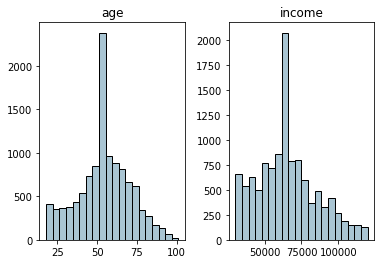

In [15]:
X_train[['age','income']].hist(bins=20, color='#A9C5D3', edgecolor='black', grid=False)

### age_quantile_range & age_quantile_label

In [16]:
quantile_list = [0, .2, .4, .6, .8, 1.]
quantiles = X_train['age'].quantile(quantile_list)
quantiles

0.0     18.0
0.2     41.0
0.4     53.0
0.6     57.0
0.8     68.0
1.0    101.0
Name: age, dtype: float64

Text(0, 0.5, 'Frequency')

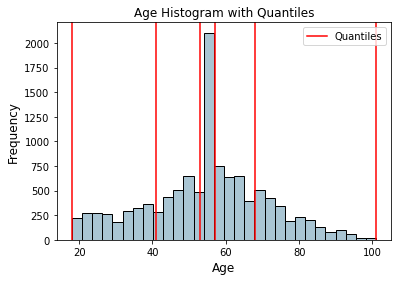

In [17]:
fig, ax = plt.subplots()
X_train['age'].hist(bins=30, color='#A9C5D3', edgecolor='black', grid=False)

for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
    
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Age Histogram with Quantiles', fontsize=12)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [18]:
# retbins = True captures the limits of each interval (can use them to cut the test set)
labels = ['0-20Q', '20-40Q', '40-60Q', '60-80Q', '80-100Q']

# calculate quantile ranges
age_quantile_range, age_intervals = pd.qcut(X_train['age'], 5, retbins=True, precision=3, duplicates='raise')

# calculate quantile labels
age_quantile_labels = pd.qcut(X_train['age'], 5, labels=labels, duplicates='raise')

In [19]:
age_intervals

array([ 18.,  41.,  53.,  57.,  68., 101.])

In [20]:
age_quantile_range.value_counts()

(57.0, 68.0]      2367
(53.0, 57.0]      2345
(17.999, 41.0]    2329
(41.0, 53.0]      2230
(68.0, 101.0]     2119
Name: age, dtype: int64

In [21]:
age_quantile_labels.value_counts()

60-80Q     2367
40-60Q     2345
0-20Q      2329
20-40Q     2230
80-100Q    2119
Name: age, dtype: int64

In [22]:
# append columns based on index location
X_train.insert(loc=2, column='age_quantile_range', value=age_quantile_range)
X_train.insert(loc=3, column='age_quantile_label', value=age_quantile_labels)

In [23]:
X_train.head()

,gender,age,age_quantile_range,age_quantile_label,customer_id,date_registered,income,transaction_amount,transaction_cnt,transaction_aos,gender_NA,income_NA,age_NA
8486,F,49.0,"(41.0, 53.0]",20-40Q,8afd61052075479bacfe7dec6a27111c,2018-03-14,75000.0,65.38,3.0,21.79,0,0,0
13892,M,68.0,"(57.0, 68.0]",60-80Q,0f4ea68d60614ce2a683c039425f160c,2017-10-09,46000.0,64.10,4.0,16.03,0,0,0
7700,Missing,55.0,"(53.0, 57.0]",40-60Q,21235376597f4d94af106ebba288304c,2015-09-12,64000.0,21.31,12.0,1.78,1,1,1
6045,M,65.0,"(57.0, 68.0]",60-80Q,9c9d2659c4ec499288a96dec70fae500,2017-01-12,76000.0,154.40,6.0,25.73,0,0,0
14096,F,35.0,"(17.999, 41.0]",0-20Q,75f1a3a88b5845feba167c6380f4dba2,2018-05-27,38000.0,17.69,6.0,2.95,0,0,0


In [24]:
# transform the test set:
    # use pandas cut method (instead of qcut) and
    # pass the quantile edges calculated in the training set

labels = ['0-20Q', '20-40Q', '40-60Q', '60-80Q', '80-100Q']

X_test_age_quantile_range = pd.cut(x=X_test['age'], bins=age_intervals)
X_test_age_quantile_labels = pd.cut(x=X_test['age'], bins=age_intervals, labels=labels)

# append columns based on index location
X_test.insert(loc=2, column='age_quantile_range', value=X_test_age_quantile_range)
X_test.insert(loc=3, column='age_quantile_label', value=X_test_age_quantile_labels)

X_test.head()

,gender,age,age_quantile_range,age_quantile_label,customer_id,date_registered,income,transaction_amount,transaction_cnt,transaction_aos,gender_NA,income_NA,age_NA
3873,F,35.0,"(18.0, 41.0]",0-20Q,b743f13d0b9f4ae0b529bb65615f7e52,2016-04-30,34000.0,162.74,13.0,12.52,0,0,0
3625,F,35.0,"(18.0, 41.0]",0-20Q,a9ef494d007245e9b94c2ff661859c51,2015-10-18,45000.0,156.98,14.0,11.21,0,0,0
3028,M,42.0,"(41.0, 53.0]",20-40Q,d8f121893be243f3a8851129a828beee,2018-07-05,56000.0,27.48,7.0,3.93,0,0,0
13814,Missing,55.0,"(53.0, 57.0]",40-60Q,9da33731c69f4d838d8dacc2f041d538,2014-11-11,64000.0,23.22,7.0,3.32,1,1,1
15398,M,39.0,"(18.0, 41.0]",0-20Q,646797fb6f194a698086d585c7d60cc3,2017-03-28,61000.0,72.83,18.0,4.05,0,0,0


### income_quantile_range & income_quantile_label

In [25]:
labels = ['0-20Q', '20-40Q', '40-60Q', '60-80Q', '80-100Q']

income_quantile_range, income_intervals = pd.qcut(X_train['income'], 5, retbins=True, 
                                                  precision=3, duplicates='raise')

income_quantile_labels = pd.qcut(X_train['income'], 5, labels=labels, duplicates='raise')

In [26]:
income_quantile_range.value_counts()

(47000.0, 61000.0]      2344
(29999.999, 47000.0]    2315
(66000.0, 82000.0]      2297
(61000.0, 66000.0]      2235
(82000.0, 120000.0]     2199
Name: income, dtype: int64

In [27]:
X_train.insert(loc=7, column='income_quantile_range', value=income_quantile_range)
X_train.insert(loc=8, column='income_quantile_label', value=income_quantile_labels)
X_train.head()

,gender,age,age_quantile_range,age_quantile_label,customer_id,date_registered,income,income_quantile_range,income_quantile_label,transaction_amount,transaction_cnt,transaction_aos,gender_NA,income_NA,age_NA
8486,F,49.0,"(41.0, 53.0]",20-40Q,8afd61052075479bacfe7dec6a27111c,2018-03-14,75000.0,"(66000.0, 82000.0]",60-80Q,65.38,3.0,21.79,0,0,0
13892,M,68.0,"(57.0, 68.0]",60-80Q,0f4ea68d60614ce2a683c039425f160c,2017-10-09,46000.0,"(29999.999, 47000.0]",0-20Q,64.10,4.0,16.03,0,0,0
7700,Missing,55.0,"(53.0, 57.0]",40-60Q,21235376597f4d94af106ebba288304c,2015-09-12,64000.0,"(61000.0, 66000.0]",40-60Q,21.31,12.0,1.78,1,1,1
6045,M,65.0,"(57.0, 68.0]",60-80Q,9c9d2659c4ec499288a96dec70fae500,2017-01-12,76000.0,"(66000.0, 82000.0]",60-80Q,154.40,6.0,25.73,0,0,0
14096,F,35.0,"(17.999, 41.0]",0-20Q,75f1a3a88b5845feba167c6380f4dba2,2018-05-27,38000.0,"(29999.999, 47000.0]",0-20Q,17.69,6.0,2.95,0,0,0


Text(0, 0.5, 'Frequency')

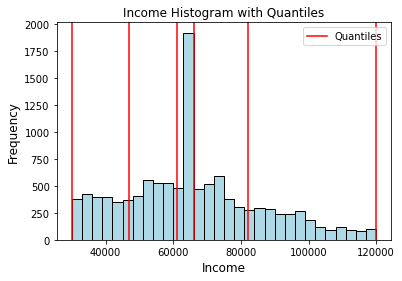

In [28]:
quantile_list = [0, .2, .4, .6, .8, 1.]
quantiles = X_train['income'].quantile(quantile_list)

fig, ax = plt.subplots()
X_train['income'].hist(bins=30, color='lightblue', edgecolor='black', grid=False)

for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
    
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Income Histogram with Quantiles', fontsize=12)
ax.set_xlabel('Income', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [29]:
income_intervals

array([ 30000.,  47000.,  61000.,  66000.,  82000., 120000.])

In [30]:
# transform the test set:
    # use pandas cut method (instead of qcut) and
    # pass the quantile edges calculated in the training set

labels = ['0-20Q', '20-40Q', '40-60Q', '60-80Q', '80-100Q']

X_test_income_quantile_range = pd.cut(x=X_test['income'], bins=income_intervals)
X_test_income_quantile_labels = pd.cut(x=X_test['income'], bins=income_intervals, labels=labels)

# append columns based on index location
X_test.insert(loc=7, column='income_quantile_range', value=X_test_income_quantile_range)
X_test.insert(loc=8, column='income_quantile_label', value=X_test_income_quantile_labels)

X_test.head()

,gender,age,age_quantile_range,age_quantile_label,customer_id,date_registered,income,income_quantile_range,income_quantile_label,transaction_amount,transaction_cnt,transaction_aos,gender_NA,income_NA,age_NA
3873,F,35.0,"(18.0, 41.0]",0-20Q,b743f13d0b9f4ae0b529bb65615f7e52,2016-04-30,34000.0,"(30000.0, 47000.0]",0-20Q,162.74,13.0,12.52,0,0,0
3625,F,35.0,"(18.0, 41.0]",0-20Q,a9ef494d007245e9b94c2ff661859c51,2015-10-18,45000.0,"(30000.0, 47000.0]",0-20Q,156.98,14.0,11.21,0,0,0
3028,M,42.0,"(41.0, 53.0]",20-40Q,d8f121893be243f3a8851129a828beee,2018-07-05,56000.0,"(47000.0, 61000.0]",20-40Q,27.48,7.0,3.93,0,0,0
13814,Missing,55.0,"(53.0, 57.0]",40-60Q,9da33731c69f4d838d8dacc2f041d538,2014-11-11,64000.0,"(61000.0, 66000.0]",40-60Q,23.22,7.0,3.32,1,1,1
15398,M,39.0,"(18.0, 41.0]",0-20Q,646797fb6f194a698086d585c7d60cc3,2017-03-28,61000.0,"(47000.0, 61000.0]",20-40Q,72.83,18.0,4.05,0,0,0


## Features: days_registered, days_reg_quantile_range, days_reg_quantile_label

In [50]:
print(X_train.date_registered.max())
print((X_train.date_registered.max() - X_train.date_registered.min()).days)

2018-07-26 00:00:00
1822


In [32]:
max_date_registered = X_train.date_registered.max()

In [33]:
X_train_days_registered = X_train['date_registered'].apply(lambda x: (max_date_registered - x).days)
X_train.insert(loc=6, column='days_registered', value=X_train_days_registered)
X_train.head()

,gender,age,age_quantile_range,age_quantile_label,customer_id,date_registered,days_registered,income,income_quantile_range,income_quantile_label,transaction_amount,transaction_cnt,transaction_aos,gender_NA,income_NA,age_NA
8486,F,49.0,"(41.0, 53.0]",20-40Q,8afd61052075479bacfe7dec6a27111c,2018-03-14,134,75000.0,"(66000.0, 82000.0]",60-80Q,65.38,3.0,21.79,0,0,0
13892,M,68.0,"(57.0, 68.0]",60-80Q,0f4ea68d60614ce2a683c039425f160c,2017-10-09,290,46000.0,"(29999.999, 47000.0]",0-20Q,64.10,4.0,16.03,0,0,0
7700,Missing,55.0,"(53.0, 57.0]",40-60Q,21235376597f4d94af106ebba288304c,2015-09-12,1048,64000.0,"(61000.0, 66000.0]",40-60Q,21.31,12.0,1.78,1,1,1
6045,M,65.0,"(57.0, 68.0]",60-80Q,9c9d2659c4ec499288a96dec70fae500,2017-01-12,560,76000.0,"(66000.0, 82000.0]",60-80Q,154.40,6.0,25.73,0,0,0
14096,F,35.0,"(17.999, 41.0]",0-20Q,75f1a3a88b5845feba167c6380f4dba2,2018-05-27,60,38000.0,"(29999.999, 47000.0]",0-20Q,17.69,6.0,2.95,0,0,0


In [34]:
X_test_days_registered = X_test['date_registered'].apply(lambda x: (max_date_registered - x).days)
X_test.insert(loc=6, column='days_registered', value=X_test_days_registered)
X_test.head()

,gender,age,age_quantile_range,age_quantile_label,customer_id,date_registered,days_registered,income,income_quantile_range,income_quantile_label,transaction_amount,transaction_cnt,transaction_aos,gender_NA,income_NA,age_NA
3873,F,35.0,"(18.0, 41.0]",0-20Q,b743f13d0b9f4ae0b529bb65615f7e52,2016-04-30,817,34000.0,"(30000.0, 47000.0]",0-20Q,162.74,13.0,12.52,0,0,0
3625,F,35.0,"(18.0, 41.0]",0-20Q,a9ef494d007245e9b94c2ff661859c51,2015-10-18,1012,45000.0,"(30000.0, 47000.0]",0-20Q,156.98,14.0,11.21,0,0,0
3028,M,42.0,"(41.0, 53.0]",20-40Q,d8f121893be243f3a8851129a828beee,2018-07-05,21,56000.0,"(47000.0, 61000.0]",20-40Q,27.48,7.0,3.93,0,0,0
13814,Missing,55.0,"(53.0, 57.0]",40-60Q,9da33731c69f4d838d8dacc2f041d538,2014-11-11,1353,64000.0,"(61000.0, 66000.0]",40-60Q,23.22,7.0,3.32,1,1,1
15398,M,39.0,"(18.0, 41.0]",0-20Q,646797fb6f194a698086d585c7d60cc3,2017-03-28,485,61000.0,"(47000.0, 61000.0]",20-40Q,72.83,18.0,4.05,0,0,0


In [43]:
days_reg_bins = pd.qcut(X_train['days_registered'], 10)
days_reg_bins.value_counts()

(516.4, 704.0]      1143
(177.8, 238.0]      1142
(238.0, 298.0]      1142
(298.0, 358.0]      1141
(-0.001, 88.9]      1139
(88.9, 177.8]       1139
(871.0, 1059.0]     1139
(1059.0, 1822.0]    1138
(704.0, 871.0]      1136
(358.0, 516.4]      1131
Name: days_registered, dtype: int64

Text(0, 0.5, 'Frequency')

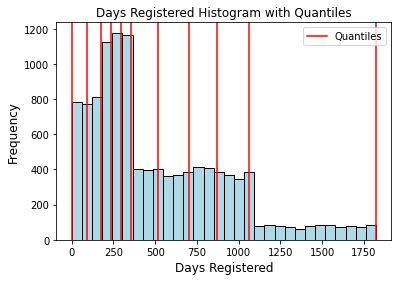

In [44]:
reg_quantile_list = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]
reg_quantiles = X_train['days_registered'].quantile(reg_quantile_list)

fig, ax = plt.subplots()
X_train['days_registered'].hist(bins=30, color='lightblue', edgecolor='black', grid=False)

for quantile in reg_quantiles:
    qvl = plt.axvline(quantile, color='r')
    
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Days Registered Histogram with Quantiles', fontsize=12)
ax.set_xlabel('Days Registered', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [47]:
# retbins = True captures the limits of each interval (can use them to cut the test set)
days_reg_labels = ['0-10Q', '10-20Q', '20-30Q', '30-40Q', '40-50Q', '50-60Q', '60-70Q', '70-80Q', '80-90Q', '90-100Q']

# calculate quantile ranges
days_reg_quantile_range, days_reg_intervals = pd.qcut(X_train['days_registered'], 10, retbins=True)

# calculate quantile labels
days_reg_quantile_labels = pd.qcut(X_train['days_registered'], 10, labels=days_reg_labels)

# insert into X_train
X_train.insert(loc=7, column='days_reg_quantile_range', value=days_reg_quantile_range)
X_train.insert(loc=8, column='days_reg_quantile_label', value=days_reg_quantile_labels)

# transform the test set:
    # use pandas cut method (instead of qcut) and
    # pass the quantile edges calculated in the training set

X_test_days_reg_quantile_range = pd.cut(x=X_test['days_registered'], bins=days_reg_intervals)
X_test_days_reg_quantile_labels = pd.cut(x=X_test['days_registered'], bins=days_reg_intervals, labels=days_reg_labels)

# append columns based on index location
X_test.insert(loc=7, column='days_reg_quantile_range', value=X_test_days_reg_quantile_range)
X_test.insert(loc=8, column='days_reg_quantile_label', value=X_test_days_reg_quantile_labels)


## Features: Offer Received, Completed, and Viewed Related Features
* num_offer_received
* num_bogo_offer_received
* num_info_offer_received 
* num_discount_offer_received
* num_offer_viewed
* num_offer_completed
* num_offer_completed_viewed
* num_offer_completed_not_viewed

In [51]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# build all base dataframes - execute functions
df_base = BaseTransformDF()
df_portfolio = df_base.portfolio_expanded(portfolio)
df_transcript = df_base.create_transcript_copy(transcript)
df_completed = df_base.create_df_base_completed(df_transcript)
df_received = df_base.create_df_base_received(df_transcript)
df_viewed = df_base.create_df_base_viewed(df_transcript)

#### Feature: num_offer_received

In [52]:
# number of total offers received per customer_id
df_num_offer_received = df_received.groupby('customer_id')['offer_received'].sum()
df_num_offer_received = df_num_offer_received.reset_index().rename(columns={'offer_received': 'num_offer_received'})

# append to X_train and X_test
X_train = X_train.merge(df_num_offer_received, how='left', on='customer_id')
X_train['num_offer_received'].fillna(0, inplace=True)

X_test = X_test.merge(df_num_offer_received, how='left', on='customer_id')
X_test['num_offer_received'].fillna(0, inplace=True)

#### Feature: num_bogo_offer_received, num_info_offer_received, & num_discount_offer_received

In [53]:
# num_bogo_offer_received, num_info_offer_received, num_discount_offer_received

# merge df_received with df_portfolio
offer_received_agg = df_received.merge(df_portfolio, how='left', on='offer_id')

# bogo
num_bogo_offer_received = offer_received_agg[offer_received_agg['type_bogo']==1].groupby('customer_id')['offer_received'].sum()
num_bogo_offer_received = num_bogo_offer_received.reset_index().rename(columns={'offer_received': 'num_bogo_offer_received'})

# informational
num_info_offer_received = offer_received_agg[offer_received_agg['type_informational']==1].groupby('customer_id')['offer_received'].sum()
num_info_offer_received = num_info_offer_received.reset_index().rename(columns={'offer_received': 'num_info_offer_received'})

# discount
num_discount_offer_received = offer_received_agg[offer_received_agg['type_discount']==1].groupby('customer_id')['offer_received'].sum()
num_discount_offer_received = num_discount_offer_received.reset_index().rename(columns={'offer_received': 'num_discount_offer_received'})

# append features to X_train and X_test
feature_list = [num_bogo_offer_received, num_info_offer_received, num_discount_offer_received]

for df_feature in feature_list:
    feature_name = df_feature.columns[1]
    X_train = X_train.merge(df_feature, how='left', on='customer_id')
    X_train[feature_name] = X_train[feature_name].fillna(0) 

for df_feature in feature_list:
    feature_name = df_feature.columns[1]
    X_test = X_test.merge(df_feature, how='left', on='customer_id')
    X_test[feature_name] = X_test[feature_name].fillna(0) 



#### Feature: num_offer_viewed

In [54]:
offer_viewed_agg = df_viewed.groupby('customer_id')['offer_viewed'].sum().reset_index()
offer_viewed_agg.rename(columns={'offer_viewed': 'num_offer_viewed'}, inplace=True)

X_train = X_train.merge(offer_viewed_agg, how='left', on='customer_id')
X_train['num_offer_viewed'].fillna(0, inplace=True)

X_test = X_test.merge(offer_viewed_agg, how='left', on='customer_id')
X_test['num_offer_viewed'].fillna(0, inplace=True)

#### Features: num_offer_completed, num_offer_completed_viewed, num_offer_completed_not_viewed

In [55]:
offer_completed_agg = trans_engage.groupby('customer_id')['offer_completed'].sum().reset_index()
offer_completed_agg.rename(columns={'offer_completed': 'num_offer_completed'}, inplace=True)

offer_completed_viewed_agg = trans_engage[trans_engage['offer_viewed']==1].groupby('customer_id')['offer_completed'].sum().reset_index()
offer_completed_viewed_agg.rename(columns={'offer_completed': 'num_offer_completed_viewed'}, inplace=True)

offer_completed_not_viewed_agg = trans_engage[trans_engage['offer_viewed']==0].groupby('customer_id')['offer_completed'].sum().reset_index()
offer_completed_not_viewed_agg.rename(columns={'offer_completed': 'num_offer_completed_not_viewed'}, inplace=True)

feature_list = [offer_completed_agg, offer_completed_viewed_agg, offer_completed_not_viewed_agg]

for df_feature in feature_list:
    feature_name = df_feature.columns[1]
    X_train = X_train.merge(df_feature, how='left', on='customer_id')
    X_train[feature_name] = X_train[feature_name].fillna(0)

for df_feature in feature_list:
    feature_name = df_feature.columns[1]
    X_test = X_test.merge(df_feature, how='left', on='customer_id')
    X_test[feature_name] = X_test[feature_name].fillna(0)

## Features: 
* num_transactions_no_oc
* num_transactions_oc_direct
* percent_oc_direct_transactions
* num_transactions_oc_indirect

In [56]:
# direct: sum of transaction_amount >= sum of rewards where offer_completed per customer_id
# indirect: sum of transaction_amount < sum of rewards where offer_completed per customer_id

# sum transaction amount >= max difficulty >>>> direct_offer_completed ELSE indirect_offer_completed

num_transactions_no_oc = trans_engage[trans_engage['offer_completed']==0].groupby('customer_id')['transaction_id'].nunique().reset_index()
num_transactions_no_oc.rename(columns={'transaction_id': 'num_transactions_no_oc'}, inplace=True)

doc = trans_engage[trans_engage['offer_completed']==1].groupby(['customer_id',
                                                                'transaction_id',
                                                                'transaction_amount'])['difficulty'].max().reset_index()

num_transactions_oc_direct = doc[doc['transaction_amount'] >= doc['difficulty']].groupby('customer_id')['transaction_id'].nunique().reset_index()
num_transactions_oc_direct.rename(columns={'transaction_id': 'num_transactions_oc_direct'}, inplace=True)

num_transactions_oc_indirect = doc[doc['transaction_amount'] < doc['difficulty']].groupby('customer_id')['transaction_id'].nunique().reset_index()
num_transactions_oc_indirect.rename(columns={'transaction_id': 'num_transactions_oc_indirect'}, inplace=True)


In [57]:
feature_list = [num_transactions_no_oc, num_transactions_oc_direct, num_transactions_oc_indirect]

for df_feature in feature_list:
    feature_name = df_feature.columns[1]    
    X_train = X_train.merge(df_feature, how='left', on='customer_id')
    X_train[feature_name] = X_train[feature_name].fillna(0)

for df_feature in feature_list:
    feature_name = df_feature.columns[1]
    X_test = X_test.merge(df_feature, how='left', on='customer_id')
    X_test[feature_name] = X_test[feature_name].fillna(0)

In [58]:
# percent_oc_direct_transacions feature
X_train['percent_oc_direct_transactions'] = round(X_train['num_transactions_oc_direct'] / X_train['transaction_cnt'], 4)
X_test['percent_oc_direct_transactions'] = round(X_test['num_transactions_oc_direct'] / X_test['transaction_cnt'], 4)


## Features
* offer_view_rate: offers viewed / offers received ratio
* offer_completion_rate: offers completed / (offers received - info offer received) ratio
* total_reward_amount
* avg_reward_per_oc_transaction
***
* transaction_oc_amount
* transaction_aos_oc
* transaction_no_oc_amount
* transaction_aos_no_oc
***
* num_bogo_offer_viewed
* num_info_offer_viewed
* num_discount_offer_viewed
***
* num_bogo_offer_completed
* num_info_offer_completed
* num_discount_offer_completed

In [62]:
# Feature: offer_view_rate = X_train.num_offer_viewed / X_train.num_offer_received
# Feature: offer_completion_rate = X_train.num_offer_completed / (X_train.num_offer_received - X_train.num_info_offer_received)

X_train['offer_view_rate'] = round(1.0 * X_train.num_offer_viewed / X_train.num_offer_received, 2)
X_train['offer_completion_rate'] = round(1.0 * X_train.num_offer_completed / (X_train.num_offer_received - X_train.num_info_offer_received), 2)

X_test['offer_view_rate'] = round(1.0 * X_test.num_offer_viewed / X_test.num_offer_received, 2)
X_test['offer_completion_rate'] = round(1.0 * X_test.num_offer_completed / (X_test.num_offer_received - X_test.num_info_offer_received), 2)


In [64]:
# Feature: total_reward_amount
total_reward_amount = trans_engage.groupby('customer_id')['reward'].sum().reset_index()
total_reward_amount.rename(columns={'reward': 'total_reward_amount'}, inplace=True)

X_train = X_train.merge(total_reward_amount, how='left', on='customer_id')
X_train['total_reward_amount'].fillna(0, inplace=True)

X_test = X_test.merge(total_reward_amount, how='left', on='customer_id')
X_test['total_reward_amount'].fillna(0, inplace=True)

In [67]:
# Feature: avg_reward_per_oc_transaction
X_train['avg_reward_per_oc_transaction'] = round(1.0 * X_train['total_reward_amount'] / (X_train['num_transactions_oc_direct'] + X_train['num_transactions_oc_indirect']), 2)
X_train['avg_reward_per_oc_transaction'].fillna(0, inplace=True)

X_test['avg_reward_per_oc_transaction'] = round(1.0 * X_test['total_reward_amount'] / (X_test['num_transactions_oc_direct'] + X_test['num_transactions_oc_indirect']), 2)
X_test['avg_reward_per_oc_transaction'].fillna(0, inplace=True)


In [69]:
# Features: transaction_oc_amount, transaction_aos_oc, transaction_no_oc_amount, transaction_aos_no_oc
transaction_oc_amount = trans_engage[trans_engage['offer_completed']==1].groupby('customer_id')['transaction_amount'].sum().reset_index()
transaction_oc_amount.rename(columns={'transaction_amount': 'transaction_oc_amount'}, inplace=True)

transaction_no_oc_amount = trans_engage[trans_engage['offer_completed']==0].groupby('customer_id')['transaction_amount'].sum().reset_index()
transaction_no_oc_amount.rename(columns={'transaction_amount': 'transaction_no_oc_amount'}, inplace=True)

X_train = X_train.merge(transaction_oc_amount, how='left', on='customer_id')
X_train['transaction_oc_amount'].fillna(0, inplace=True)
X_train['transaction_aos_oc'] = 1.0 * X_train['transaction_oc_amount'] / (X_train['num_transactions_oc_direct'] + X_train['num_transactions_oc_indirect'])
X_train['transaction_aos_oc'].fillna(0, inplace=True)

X_train = X_train.merge(transaction_no_oc_amount, how='left', on='customer_id')
X_train['transaction_no_oc_amount'].fillna(0, inplace=True)
X_train['transaction_aos_no_oc'] = 1.0 * X_train['transaction_no_oc_amount'] / X_train['num_transactions_no_oc']
X_train['transaction_aos_no_oc'].fillna(0, inplace=True)

X_test = X_test.merge(transaction_oc_amount, how='left', on='customer_id')
X_test['transaction_oc_amount'].fillna(0, inplace=True)
X_test['transaction_aos_oc'] = 1.0 * X_test['transaction_oc_amount'] / (X_test['num_transactions_oc_direct'] + X_test['num_transactions_oc_indirect'])
X_test['transaction_aos_oc'].fillna(0, inplace=True)

X_test = X_test.merge(transaction_no_oc_amount, how='left', on='customer_id')
X_test['transaction_no_oc_amount'].fillna(0, inplace=True)
X_test['transaction_aos_no_oc'] = 1.0 * X_test['transaction_no_oc_amount'] / X_test['num_transactions_no_oc']
X_test['transaction_aos_no_oc'].fillna(0, inplace=True)


In [70]:
# Features: num_bogo_offer_viewed, num_info_offer_viewed, num_discount_offer_viewed

# merge df_viewed with df_portfolio
offer_viewed_agg = df_viewed.merge(df_portfolio, how='left', on='offer_id')

# bogo
num_bogo_offer_viewed = offer_viewed_agg[offer_viewed_agg['type_bogo']==1].groupby('customer_id')['offer_viewed'].sum()
num_bogo_offer_viewed = num_bogo_offer_viewed.reset_index().rename(columns={'offer_viewed': 'num_bogo_offer_viewed'})

# informational
num_info_offer_viewed = offer_viewed_agg[offer_viewed_agg['type_informational']==1].groupby('customer_id')['offer_viewed'].sum()
num_info_offer_viewed = num_info_offer_viewed.reset_index().rename(columns={'offer_viewed': 'num_info_offer_viewed'})

# discount
num_discount_offer_viewed = offer_viewed_agg[offer_viewed_agg['type_discount']==1].groupby('customer_id')['offer_viewed'].sum()
num_discount_offer_viewed = num_discount_offer_viewed.reset_index().rename(columns={'offer_viewed': 'num_discount_offer_viewed'})

# append features to X_train and X_test
feature_list = [num_bogo_offer_viewed, num_info_offer_viewed, num_discount_offer_viewed]

for df_feature in feature_list:
    feature_name = df_feature.columns[1]
    X_train = X_train.merge(df_feature, how='left', on='customer_id')
    X_train[feature_name] = X_train[feature_name].fillna(0) 

for df_feature in feature_list:
    feature_name = df_feature.columns[1]
    X_test = X_test.merge(df_feature, how='left', on='customer_id')
    X_test[feature_name] = X_test[feature_name].fillna(0) 


In [71]:
# Features: num_bogo_offer_completed, num_info_offer_completed, num_discount_offer_completed

# merge df_completed with df_portfolio
offer_completed_agg = df_completed.merge(df_portfolio, how='left', on='offer_id')

# bogo
num_bogo_offer_completed = offer_completed_agg[offer_completed_agg['type_bogo']==1].groupby('customer_id')['offer_completed'].sum()
num_bogo_offer_completed = num_bogo_offer_completed.reset_index().rename(columns={'offer_completed': 'num_bogo_offer_completed'})

# informational
num_info_offer_completed = offer_completed_agg[offer_completed_agg['type_informational']==1].groupby('customer_id')['offer_completed'].sum()
num_info_offer_completed = num_info_offer_completed.reset_index().rename(columns={'offer_completed': 'num_info_offer_completed'})

# discount
num_discount_offer_completed = offer_completed_agg[offer_completed_agg['type_discount']==1].groupby('customer_id')['offer_completed'].sum()
num_discount_offer_completed = num_discount_offer_completed.reset_index().rename(columns={'offer_completed': 'num_discount_offer_completed'})

# append features to X_train and X_test
feature_list = [num_bogo_offer_completed, num_info_offer_completed, num_discount_offer_completed]

for df_feature in feature_list:
    feature_name = df_feature.columns[1]
    X_train = X_train.merge(df_feature, how='left', on='customer_id')
    X_train[feature_name] = X_train[feature_name].fillna(0) 

for df_feature in feature_list:
    feature_name = df_feature.columns[1]
    X_test = X_test.merge(df_feature, how='left', on='customer_id')
    X_test[feature_name] = X_test[feature_name].fillna(0) 


## Features
* median_offer_duration
* avg_offer_completion_time = sum(offer_completed_time - offer_received_time) / count(offer_completed)
* avg hours between transactions if 2 or more transactions per customer_id
* num_oc_ch_social
* num_oc_ch_web
* num_oc_ch_mobile
* num_oc_ch_email

### Feature: median_offer_duration

In [72]:
# take median value of all offer durations per customer_id
median_offer_duration = trans_engage[trans_engage['offer_completed']==1].groupby('customer_id')['duration'].median().reset_index()
median_offer_duration.rename(columns={'duration': 'median_offer_duration'}, inplace=True)
median_offer_duration.head()

X_train = X_train.merge(median_offer_duration, how='left', on='customer_id')
X_train['median_offer_duration'].fillna(0, inplace=True)

X_test = X_test.merge(median_offer_duration, how='left', on='customer_id')
X_test['median_offer_duration'].fillna(0, inplace=True)


### Feature: avg_offer_completion_time

In [73]:
# avg_offer_completion_time = sum(offer_completed_time - offer_received_time) / count(offer_completed)
feature_columns = ['customer_id','offer_completed_time','offer_received_time','offer_completed']
avg_oc_time_stg = trans_engage[trans_engage['offer_completed']==1][feature_columns]
avg_oc_time_stg['oct-ort'] = avg_oc_time_stg['offer_completed_time'] - avg_oc_time_stg['offer_received_time']

sum_diff_time = avg_oc_time_stg.groupby('customer_id')['oct-ort'].sum().reset_index()
sum_offers_completed = avg_oc_time_stg.groupby('customer_id')['offer_completed'].sum().reset_index()

avg_oc_time_stg_v2 = sum_diff_time.merge(sum_offers_completed, how='left', on='customer_id')
avg_oc_time_stg_v2['avg_offer_completion_time'] = 1.0 * avg_oc_time_stg_v2['oct-ort'] / avg_oc_time_stg_v2['offer_completed']

X_train = X_train.merge(avg_oc_time_stg_v2[['customer_id','avg_offer_completion_time']], how='left', on='customer_id')
X_train['avg_offer_completion_time'].fillna(0, inplace=True)

X_test = X_test.merge(avg_oc_time_stg_v2[['customer_id','avg_offer_completion_time']], how='left', on='customer_id')
X_test['avg_offer_completion_time'].fillna(0, inplace=True)


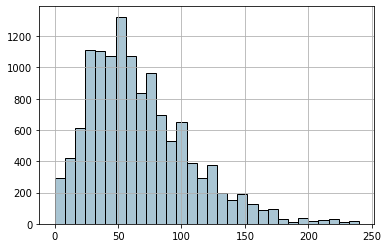

In [74]:
avg_oc_time_stg_v2.avg_offer_completion_time.hist(bins=30, color='#A9C5D3', edgecolor='black')

### Feature: avg_hrs_bw_transactions

In [75]:
# For the function to work, starbucks_transaction_engagement.csv.gz has to be imported as a dataframe
    # and call it, df_trans_engage
# Function iterates over each customer_id and creates a list of all transaction_time per transaction_id
# and calculates the difference between current and previous transaction, and then averages the spreads.
# This calculates the average hours between transactions

def avg_hrs_bw_trans(df_trans_engage) -> pd.DataFrame:
    
    df_transactions_stg = df_trans_engage.groupby(['transaction_id', 'customer_id', 'transaction_time'])['transaction_amount'].max().reset_index()
    list_of_ids = df_transactions_stg.customer_id.unique()
    
    customer_ids = []
    avg_hrs_bw_transactions = []
    
    counter = 0
    for id_ in list_of_ids:
        transaction_times = df_trans_engage[df_trans_engage['customer_id']==id_]['transaction_time']
        transaction_times = sorted(transaction_times)
        
        if len(transaction_times) > 1:
            diff_list = []
            n = len(transaction_times) - 1
            for idx in range(n):
                t1 = transaction_times[idx]
                t2 = transaction_times[idx+1]
                diff = t2 - t1
                diff_list.append(diff)
            
            avg_hrs = np.mean(diff_list)
            customer_ids.append(id_)
            avg_hrs_bw_transactions.append(avg_hrs)
            counter += 1
        else:
            customer_ids.append(id_)
            avg_hrs_bw_transactions.append(0)
            counter += 1
        
        if counter % 1000 == 0:
            print('Number of customer_ids complete: {}'.format(counter))
            
    df = pd.DataFrame({'customer_id': customer_ids, 'avg_hrs_bw_transactions': avg_hrs_bw_transactions})
    print('df build complete.')
    return df

In [76]:
%%time

file_name = 'starbucks_transaction_engagement.csv.gz' 
file_gzip = os.path.join(os.getcwd(), 'data', file_name)

df_trans_engage = pd.read_csv(file_gzip, compression='gzip')

avg_hrs_trans = avg_hrs_bw_trans(df_trans_engage)

# CPU times: user 2min 52s, sys: 504 ms, total: 2min 53s
# Wall time: 2min 53s

Number of customer_ids complete: 1000
Number of customer_ids complete: 2000
Number of customer_ids complete: 3000
Number of customer_ids complete: 4000
Number of customer_ids complete: 5000
Number of customer_ids complete: 6000
Number of customer_ids complete: 7000
Number of customer_ids complete: 8000
Number of customer_ids complete: 9000
Number of customer_ids complete: 10000
Number of customer_ids complete: 11000
Number of customer_ids complete: 12000
Number of customer_ids complete: 13000
Number of customer_ids complete: 14000
Number of customer_ids complete: 15000
Number of customer_ids complete: 16000
df build complete.
CPU times: user 2min 36s, sys: 322 ms, total: 2min 36s
Wall time: 2min 36s


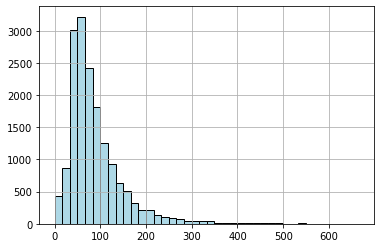

In [77]:
avg_hrs_trans.avg_hrs_bw_transactions.hist(bins=40, color='lightblue', edgecolor='black')

In [78]:
# append to X_train and X_test
X_train = X_train.merge(avg_hrs_trans, how='left', on='customer_id')
X_train['avg_hrs_bw_transactions'].fillna(0, inplace=True)

X_test = X_test.merge(avg_hrs_trans, how='left', on='customer_id')
X_test['avg_hrs_bw_transactions'].fillna(0, inplace=True)

### Features: num_oc_ch_social, num_oc_ch_web, num_oc_ch_mobile, num_oc_ch_email

In [79]:
# num_oc_ch_social, num_oc_ch_web, num_oc_ch_mobile, num_oc_ch_email

num_oc_by_channel = trans_engage[trans_engage['offer_completed']==1].groupby('customer_id')['ch_web',
                                                                        'ch_social',
                                                                        'ch_mobile',
                                                                        'ch_email'].sum().reset_index()
num_oc_by_channel.rename(columns={'ch_web': 'num_oc_ch_web',
                                  'ch_social': 'num_oc_ch_social',
                                  'ch_mobile': 'num_oc_ch_mobile',
                                  'ch_email': 'num_oc_ch_email'}, inplace=True)

X_train = X_train.merge(num_oc_by_channel, how='left', on='customer_id')

X_test = X_test.merge(num_oc_by_channel, how='left', on='customer_id')

features = ['num_oc_ch_social', 'num_oc_ch_web', 'num_oc_ch_mobile', 'num_oc_ch_email']
for feature in features:
    X_train[feature].fillna(0, inplace=True)
    X_test[feature].fillna(0, inplace=True)


## Features
* avg_offer_received_feq
* info_view_rate

In [5]:
# Avg offer received frequency (avg_offer_received_freq)
import numpy as np
from base_transforms import BaseTransformDF

def avg_offer_received_frequency():
    transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
    df_base = BaseTransformDF()
    df_transcript = df_base.create_transcript_copy(transcript)
    df_received = df_base.create_df_base_received(df_transcript)

    customer_ids = df_received.customer_id.unique()
    customer_id = []
    avg_or_freq = []

    counter = 1
    for id_ in customer_ids:
        time_series = df_received[df_received['customer_id']==id_].offer_received_time.to_list()
        n = len(time_series)

        if n > 1:
            t_diff = []
            for idx in range(n-1):
                t1 = time_series[idx]
                t2 = time_series[idx+1]
                diff = t2 - t1
                t_diff.append(diff)

            t_mean = np.mean(t_diff)
            avg_or_freq.append(t_mean)
            customer_id.append(id_)
            counter += 1
        else:
            t_single = time_series[0]
            avg_or_freq.append(t_single)
            customer_id.append(id_)
            counter += 1

        if counter % 1000 == 0:
            print("Number of customer_ids completed: {}".format(counter))

    df = pd.DataFrame({'customer_id': customer_id, 'avg_offer_received_freq': avg_or_freq})

    return df

In [6]:
%%time 
avg_offer_received_freq = avg_offer_received_frequency()

Number of customer_ids completed: 1000
Number of customer_ids completed: 2000
Number of customer_ids completed: 3000
Number of customer_ids completed: 4000
Number of customer_ids completed: 5000
Number of customer_ids completed: 6000
Number of customer_ids completed: 7000
Number of customer_ids completed: 8000
Number of customer_ids completed: 9000
Number of customer_ids completed: 10000
Number of customer_ids completed: 11000
Number of customer_ids completed: 12000
Number of customer_ids completed: 13000
Number of customer_ids completed: 14000
Number of customer_ids completed: 15000
Number of customer_ids completed: 16000
CPU times: user 1min 20s, sys: 283 ms, total: 1min 20s
Wall time: 1min 20s


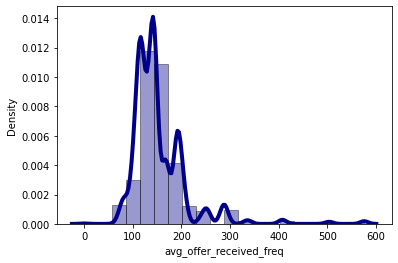

In [7]:
import seaborn as sns

# Density Plot and Histogram 
sns.distplot(avg_offer_received_freq['avg_offer_received_freq'], 
             hist=True, 
             kde=True, 
             bins=20, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [8]:
X_train = X_train.merge(avg_offer_received_freq, how='left', on='customer_id')
X_train['avg_offer_received_freq'].fillna(0, inplace=True)

X_test = X_test.merge(avg_offer_received_freq, how='left', on='customer_id')
X_test['avg_offer_received_freq'].fillna(0, inplace=True)


In [9]:
# info view rate

X_train['info_view_rate'] = 1.0 * X_train['num_info_offer_viewed'] / X_train['num_info_offer_received']
X_train['info_view_rate'].fillna(0, inplace=True)

X_test['info_view_rate'] = 1.0 * X_test['num_info_offer_viewed'] / X_test['num_info_offer_received']
X_test['info_view_rate'].fillna(0, inplace=True)


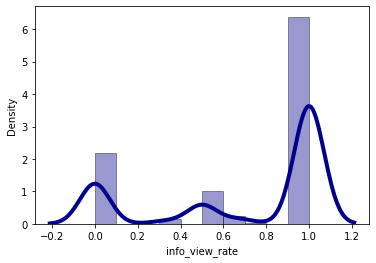

In [13]:
sns.distplot(X_train[X_train['num_info_offer_received'] > 0]['info_view_rate'], 
             hist=True, 
             kde=True, 
             bins=10, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

## Save X_train & X_test as csv.gzip files

In [14]:
print(X_train.shape)
print(X_test.shape)

(11390, 53)
(5610, 53)


In [15]:
# write df to gzipped csv file
curr_dir = os.getcwd()
data_dir = 'data'

train_file = 'train_starbucks.csv.gz'
test_file = 'test_starbucks.csv.gz'

train_file_path = os.path.join(curr_dir, data_dir, train_file)
test_file_path = os.path.join(curr_dir, data_dir, test_file)

try:
    X_train.to_csv(train_file_path, index=False, compression='gzip')
    print("Success: {} created".format(train_file))
    print("  File_path_name: {}".format(train_file_path))
    
    X_test.to_csv(test_file_path, index=False, compression='gzip')
    print("Success: {} created".format(test_file))
    print("  File_path_name: {}".format(test_file_path))
    
except:
    print("Error: File creations failed.")

Success: train_starbucks.csv.gz created
  File_path_name: /Users/dlee/ds/repos/udacity-starbucks-capstone-project/data/train_starbucks.csv.gz
Success: test_starbucks.csv.gz created
  File_path_name: /Users/dlee/ds/repos/udacity-starbucks-capstone-project/data/test_starbucks.csv.gz


## Import X_train and X_test from saved files

In [ ]:
%%time

train_file = 'train_starbucks.csv.gz'
test_file = 'test_starbucks.csv.gz'

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', <number of rows>)

train_file_gzip = os.path.join(os.getcwd(), 'data', train_file)
test_file_gzip = os.path.join(os.getcwd(), 'data', test_file)

X_train = pd.read_csv(train_file_gzip, compression='gzip')
X_test = pd.read_csv(test_file_gzip, compression='gzip')

print(X_train.shape)
print(X_test.shape)